# Planify - Graph Neural Network

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
    <ul>
        <li><a href="#Imports">Imports</a></li>
        <li><a href="#func">Functions used</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#model">GNN Model</a></li>
    <ul>
        <li><a href="#dataLoader">Data Loader</a></li>
        <li><a href="#archi">Architecture</a></li>
        <li><a href="#train">Training</a></li> 
        <li><a href="#eval">Evaluation</a></li>
    </ul>
</ul>

<a id='intro'></a>
## Introduction

> This notebook getting garphs in the Networkx format from the `Creating Graphs` notebook. And its main goal is to make the GNN model.

In [1]:
# Used for vsCode only to show tqdm process
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

<a id='Imports'></a>
### Imports

In [2]:
# Only for kaggle
# !pip install torch_geometric

In [3]:
# Not included packages in kaggle

# Install torch_geometric
# !pip install /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl -q
# !pip install /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl -q

# # # library for getting distinct colores
# !pip install distinctipy -q

In [1]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import distinctipy
import random
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool


# for my pc [linux]
# url = '/media/mo/DATA/Grad/Planify_Dataset/Graph/Planify_Graphs.pkl'

# for my pc [windows]
# url = "D:\Grad\Planify_Dataset\Graph\Planify_Graphs.pkl"
url_real = "D:\Grad\Planify_Dataset\Planify_Graphs\Graphs_real.pkl"
url_all_toLiving = "D:\Grad\Planify_Dataset\Planify_Graphs\Graphs_living_to_all.pkl"
# url_boundary = r"D:\Grad\Planify_Dataset\Graph\graphs\boundaries.pkl"

# for kaggle
# url = '/kaggle/input/planify-graphs/Planify_Graphs.pkl'

<a id='func'></a>
### Functions used

In [2]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [3]:
def draw_graph(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    colormap = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    
    nx.draw(G, pos=pos, node_size=scales, node_color=colormap, with_labels=True, font_size=12)
    
    # Drawing the graph inside a good boundary.
    x_coords  = [pos[node][0] for node in pos]
    y_coords  = [pos[node][1] for node in pos]
    threshold = max(scales) / 100
    
    plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.ylim(min(y_coords) - threshold, max(y_coords) + threshold)

def draw_graph_boundary(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['centroid'][0], -G.nodes[node]['centroid'][1])  for node in G.nodes}
    
    door_color = '#90EE90'
    other_nodes_color = '#0A2A5B'
    color_map = [door_color if G.nodes[node]['type'] == 1 else other_nodes_color for node in G.nodes]
    
    nx.draw(G, pos=pos, with_labels=True, node_color=color_map, font_color='w', font_size=12)

# For statistics
def get_max_min_x_y(graphs):
    max_x = 0
    max_y = 0
    min_x = float('inf')
    min_y = float('inf')
    
    for G in tqdm(graphs, desc="Getting maximum x, y", total=len(graphs)):
        max_x_in_graph = G.x.T[1].max().item()
        max_y_in_graph = G.x.T[2].max().item()
        
        min_x_in_graph = G.x.T[1].min().item()
        min_y_in_graph = G.x.T[2].min().item()
        
        if max_x_in_graph > max_x:
            max_x = max_x_in_graph
        if max_y_in_graph > max_y:
            max_y = max_y_in_graph
            
        if min_x_in_graph < min_x:
            min_x = min_x_in_graph
        if min_y_in_graph < min_y:
            min_y = min_y_in_graph
            
    values = {'max_x': max_x, 'max_y': max_y, 'min_x': min_x, 'min_y': min_y}
    return values

def get_all_x_y(graphs):
    """Get all values of x and y from all graphs
        Input: list of graphs
        Output: x and y as pandas series
    """
    x = []
    y = []

    for G in tqdm(graphs, desc="getting all Xs, Ys", total=len(graphs)):
        for i in range(len(G.x)):
            x.append(G.x[i][1].item())
            y.append(G.x[i][2].item())

    x = pd.Series(x)
    y = pd.Series(y)

    return x, y

def boxplot_centrValues(x, y):
    fig, ax = plt.subplots()

    # Plot the boxplots
    ax.boxplot([x, y])

    # Set the xtick labels
    ax.set_xticklabels(['x', 'y'])

    # Add axis labels and title
    ax.set_xlabel('Data')
    ax.set_ylabel('Value')
    ax.set_title('Boxplot of x and y in all graphs')

    # Show the plot
    plt.show()
    
def plot_histograms(x, y):
    x.hist(density=True, bins=100, alpha=0.6, label='x');
    y.hist(density=True, bins=100, alpha=0.3, label='y');
    plt.legend();
    plt.title('Distribution of x and y');

<a id='wrangling'></a>
## Data wrangling


### Real Graphs pipline

In [4]:
with open(url_real, 'rb') as f:
    real_graphs = pickle.load(f)
    
G = real_graphs[1911]
print(G)

Graph with 8 nodes and 13 edges


In [5]:
# Converting networkx graphs to pytorchGeo graphs
features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']
real_graphs_pyTorch = []
for G in tqdm(real_graphs):
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['distance'])
    # Normalizing feature matrix (x)
    # G_new = T.NormalizeFeatures()(G_new)
    
    real_graphs_pyTorch.append(G_new)

real_graphs_pyTorch[0]

100%|██████████| 80787/80787 [01:16<00:00, 1055.45it/s]


Data(edge_index=[2, 16], roomType_name=[6], rec_w=[6], rec_h=[6], roomSize=[6], x=[6, 3], edge_attr=[16, 1])

In [6]:
x, y = get_all_x_y(real_graphs_pyTorch)
x.max(), y.max(), x.min(), y.min()

getting all Xs, Ys: 100%|██████████| 80787/80787 [00:08<00:00, 9292.65it/s] 


(234.5, 234.0, 20.0, 20.5)

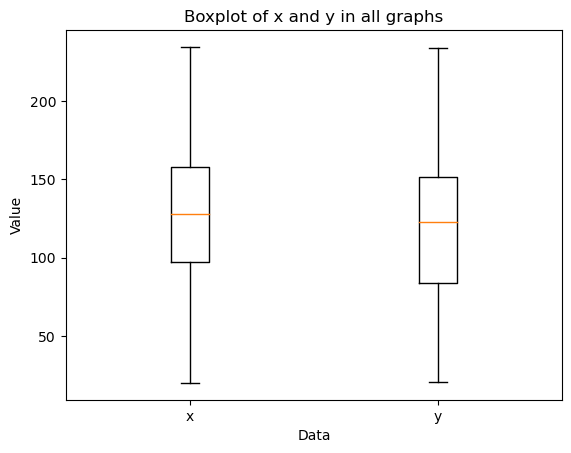

In [7]:
# making box plot for x and y for the graphs
boxplot_centrValues(x, y)

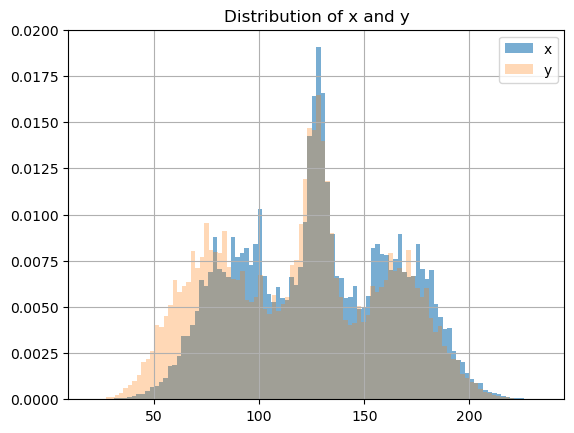

In [8]:
plot_histograms(x, y)

> And we saw the box plots so there is no outliers, and the distribution is normal
> 
> We will use z-score normalization, by taking a general mean and std for each of x and y

In [9]:
# print(f"Maximun x: {max_x}, Maximum y: {max_y}, Minimum x: {min_x}, Minimum y: {min_y}")
print("And we saw the box plots so there is no outliers, and the distribution is normal")
x_mean = x.mean()
y_mean = y.mean()
x_std  = x.std()
y_std  = y.std()
print("We will use z-score normalization")

And we saw the box plots so there is no outliers, and the distribution is normal
We will use z-score normalization


> There are many types of `rooms` but we will give them a defualt number = 1.
> So, also we will decrease the embedings to be between 0:6

In [10]:
print(f'Befor: G_1 embedings are: {real_graphs_pyTorch[1].x}')
for G in tqdm(real_graphs_pyTorch, total=len(real_graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())
        
        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6


print(f'After: G_1 embedings are: {real_graphs_pyTorch[1].x}')

Befor: G_1 embedings are: tensor([[  0.0000, 116.3068, 141.6314],
        [  1.0000, 181.5403, 165.1201],
        [  3.0000, 120.7426, 100.7954],
        [  7.0000, 132.6687, 167.8575],
        [  7.0000, 152.0459, 100.5418],
        [  3.0000, 192.0000, 127.0000],
        [  2.0000,  59.5000,  55.5000]], dtype=torch.float64)


100%|██████████| 80787/80787 [00:07<00:00, 11365.97it/s]

After: G_1 embedings are: tensor([[  0.0000, 116.3068, 141.6314],
        [  1.0000, 181.5403, 165.1201],
        [  3.0000, 120.7426, 100.7954],
        [  1.0000, 132.6687, 167.8575],
        [  1.0000, 152.0459, 100.5418],
        [  3.0000, 192.0000, 127.0000],
        [  2.0000,  59.5000,  55.5000]], dtype=torch.float64)


> Normalization for the centroids columns & hot encoding the type one for the graphs data.

In [11]:
for G in tqdm(real_graphs_pyTorch, total=len(real_graphs_pyTorch)):
    x = G.x # The feature matrix
    for i in [1, 2]:
        # mean = torch.mean(x[:, i])
        # std  = torch.std(x[:, i])
        if i == 1:
            mean = x_mean
            std  = x_std
        else:
            mean = y_mean
            std  = y_std
            
        normalized_column = (x[:, i] - mean) / std
        G.x[:, i] = normalized_column
    
    # One hot encoding for the first column [type of rooms]
    first_column_encodings = F.one_hot(G.x[:, 0].long(), 7)
    
    G.x = torch.cat([first_column_encodings, G.x[:, 1:]], axis=1)

100%|██████████| 80787/80787 [00:15<00:00, 5111.33it/s]


In [12]:
print(f"Now, we could return back to real values: {real_graphs_pyTorch[1].x[:, -2] * x_std + x_mean}")

Now, we could return back to real values: tensor([116.3068, 181.5403, 120.7426, 132.6687, 152.0459, 192.0000,  59.5000],
       dtype=torch.float64)


### All nodes to living graphs pipline

In [13]:
with open(url_all_toLiving, 'rb') as f:
    living_graphs = pickle.load(f)
    
L = living_graphs[1911]
print(L)

Graph with 8 nodes and 7 edges


In [14]:
# Converting networkx graphs to pytorchGeo graphs
features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']
living_graphs_pyTorch = []
for G in tqdm(living_graphs):
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['distance'])
    # Normalizing feature matrix (x)
    # G_new = T.NormalizeFeatures()(G_new)
    
    living_graphs_pyTorch.append(G_new)

living_graphs_pyTorch[0]

100%|██████████| 80787/80787 [01:29<00:00, 904.48it/s] 


Data(edge_index=[2, 10], roomType_name=[6], rec_w=[6], rec_h=[6], roomSize=[6], x=[6, 3], edge_attr=[10, 1])

In [15]:
x, y = get_all_x_y(living_graphs_pyTorch)
x.max(), y.max(), x.min(), y.min()

getting all Xs, Ys: 100%|██████████| 80787/80787 [00:09<00:00, 8913.38it/s]


(234.5, 234.0, 20.0, 20.5)

> And we saw the box plots so there is no outliers, and the distribution is normal
> 
> We will use z-score normalization, by taking a general mean and std for each of x and y

In [16]:
xLiving_mean = x.mean()
yLiving_mean = y.mean()
xLiving_std  = x.std()
yLiving_std  = y.std()

> There are many types of `rooms` but we will give them a defualt number = 1.
> So, also we will decrease the embedings to be between 0:6

In [17]:
print(f'Befor: L_1 embedings are: {living_graphs_pyTorch[1].x}')
for G in tqdm(living_graphs_pyTorch, total=len(living_graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())
        
        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6


print(f'After: G_1 embedings are: {living_graphs_pyTorch[1].x}')

Befor: L_1 embedings are: tensor([[  0.0000, 116.3068, 141.6314],
        [  1.0000, 181.5403, 165.1201],
        [  2.0000,  59.5000,  55.5000],
        [  3.0000, 192.0000, 127.0000],
        [  3.0000, 120.7426, 100.7954],
        [  7.0000, 132.6687, 167.8575],
        [  7.0000, 152.0459, 100.5418]], dtype=torch.float64)


100%|██████████| 80787/80787 [00:07<00:00, 11426.33it/s]

After: G_1 embedings are: tensor([[  0.0000, 116.3068, 141.6314],
        [  1.0000, 181.5403, 165.1201],
        [  2.0000,  59.5000,  55.5000],
        [  3.0000, 192.0000, 127.0000],
        [  3.0000, 120.7426, 100.7954],
        [  1.0000, 132.6687, 167.8575],
        [  1.0000, 152.0459, 100.5418]], dtype=torch.float64)


> Normalization for the centroids columns & hot encoding the type one for the graphs data.

In [18]:
for G in tqdm(living_graphs_pyTorch, total=len(living_graphs_pyTorch)):
    x = G.x # The feature matrix
    for i in [1, 2]:
        # mean = torch.mean(x[:, i])
        # std  = torch.std(x[:, i])
        if i == 1:
            mean = xLiving_mean
            std  = xLiving_std
        else:
            mean = yLiving_mean
            std  = yLiving_std
            
        normalized_column = (x[:, i] - mean) / std
        G.x[:, i] = normalized_column
    
    # One hot encoding for the first column [type of rooms]
    first_column_encodings = F.one_hot(G.x[:, 0].long(), 7)
    
    G.x = torch.cat([first_column_encodings, G.x[:, 1:]], axis=1)

100%|██████████| 80787/80787 [00:15<00:00, 5381.79it/s]


<a id='model'></a>
## GNN Model

<a id='dataLoader'></a>
### Data Loader

In [371]:
class Planify_Dataset(Dataset):
    def __init__(self, real_graphs, living_graphs):
        self.real_graphs = real_graphs
        self.living_graphs = living_graphs
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def __len__(self):
        return len(self.real_graphs)

    def __getitem__(self, index):
        G_real   = self.real_graphs[index].clone().to(self.device)
        G_living = self.living_graphs[index].clone().to(self.device) 
        # shuffling nodes inside the same graph
        # permutation = torch.randperm(G.num_nodes).to(self.device)
        
        # G.x = G.x[permutation]
        # G.edge_index = permutation[G.edge_index]
        # G.rec_w = G.rec_w[permutation]
        # G.rec_h = G.rec_h[permutation]
        # G.edge_attr = G.edge_attr[permutation]
        
        nu_nodes = G_real.x.shape[0]
        
        # padded_x = torch.nn.functional.pad(G.x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
        
        edge_index = G_real.edge_index
        real_adj_matrix = torch.zeros((nu_nodes, nu_nodes), dtype=torch.float32)
        
        # Set the values in the adjacency matrix to 1 where there are edges in the graph
        real_adj_matrix[edge_index[0], edge_index[1]] = 1
        real_adj_matrix[edge_index[1], edge_index[0]] = 1  # if the graph is undirected
        
        
        # Creating a new graph with comming data from the living graphs with the adj matrix of the real graph we need.
        # data = Data(x=G_living.x, edge_index=G_living.edge_index, edge_attr=G_living.edge_attr, target_adj=real_adj_matrix)
        
        # Considering only the upeer half of the matrix (including the diagonal)
        # adj_matrix = torch.triu(adj_matrix).squeeze()
        
        # print(G_real.x.shape, G_living.x.shape, G_living.edge_index.shape, real_adj_matrix.shape)
        # data = {
        #     'x'  : G_real.x.to(torch.float32),
        #     'edge_index_living': G_living.edge_index,
        #     'adj_real': real_adj_matrix
        # }
        
        data = {
            'x': G_living.x.to(torch.float32),
            'edge_index': G_living.edge_index,
            'real_adj': real_adj_matrix
        }
        return data

In [372]:
edge = int(len(real_graphs_pyTorch) * 0.3)

In [378]:
batch_size = 1
train_dataset = Planify_Dataset(real_graphs_pyTorch[:100], living_graphs_pyTorch[:100])
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = Planify_Dataset(real_graphs_pyTorch[10000: 15000], living_graphs_pyTorch[10000: 15000])
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Planify_Dataset(real_graphs_pyTorch[-10:], living_graphs_pyTorch[-10:])
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [379]:
# Saving model function
import os

# checkpoint_dir = '/kaggle/working/checkpoints'
# checkpoint_dir = '/media/mo/DATA/Grad/Planify_Dataset/Graph/checkpoints'
checkpoint_dir = "./checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    

def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch.pt')
    # Saving model each 15 epochs
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, checkpoint_path)
    
    print('Model saved :)')

<a id='archi'></a>
### Architecture

In [380]:
class GraphEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, x, edge_index):
        """
        x: feature matrix of shape [num_nodes, num_features]
        edge_index: all nodes to living graphs' edge index matrix of shape [2, num_edges]
        
        """
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        
        return x

class GraphDecoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphDecoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, x, edge_index):
        """
        x: feature matrix of shape [num_nodes, num_features]
        edge_index: all nodes to living graphs' edge index matrix of shape [2, num_edges]
        
        """
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        
        x = torch.matmul(x, x.T)
        x = torch.sigmoid(x)
        
        return x

class GraphAutoEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphAutoEncoder, self).__init__()
        self.encoder = GraphEncoder(in_channels, hidden_channels, out_channels)
        self.decoder = GraphDecoder(out_channels, hidden_channels, in_channels)
        
    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        adj = self.decoder(z, edge_index)

        return adj

nu_features = real_graphs_pyTorch[0].x.shape[1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphAutoEncoder(nu_features, 64, nu_features).to(device)
model

GraphAutoEncoder(
  (encoder): GraphEncoder(
    (conv1): GCNConv(9, 64)
    (conv2): GCNConv(64, 64)
    (conv3): GCNConv(64, 9)
  )
  (decoder): GraphDecoder(
    (conv1): GCNConv(9, 64)
    (conv2): GCNConv(64, 64)
    (conv3): GCNConv(64, 9)
  )
)

In [381]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
critereon = nn.BCELoss()

In [384]:
for epochs in range(10):
    train_loss = 0
    model.train()
    
    for batch in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        
        x = batch['x'].squeeze()
        edge_index = batch['edge_index'].squeeze()
        adj_real = batch['real_adj'].squeeze().to(device)
        
        adj_pred = model(x, edge_index).squeeze()
        loss = critereon(adj_pred, adj_real)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    print(train_loss / len(train_loader))

100%|██████████| 100/100 [00:01<00:00, 54.73it/s]


0.693188504576683


100%|██████████| 100/100 [00:02<00:00, 48.81it/s]


0.6926908898353576


100%|██████████| 100/100 [00:02<00:00, 44.01it/s]


0.6923176008462906


100%|██████████| 100/100 [00:02<00:00, 48.03it/s]


0.6917815411090851


100%|██████████| 100/100 [00:01<00:00, 50.61it/s]


0.691483725309372


100%|██████████| 100/100 [00:01<00:00, 53.55it/s]


0.6911958891153336


100%|██████████| 100/100 [00:01<00:00, 57.96it/s]


0.6908152776956559


100%|██████████| 100/100 [00:02<00:00, 45.09it/s]


0.6905279421806335


 96%|█████████▌| 96/100 [00:02<00:00, 47.95it/s]


KeyboardInterrupt: 

In [85]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), desc="Planifying", total=len(train_loader)):
        optimizer.zero_grad()
        # Forward pass
        x   = data['G'].x
        real_adj = data['adj'].squeeze()
        pred_adj = model(x)

        loss = criterion(pred_adj, real_adj)
        # Backward pass
        loss.backward()
        
        # Updating parameters
        optimizer.step()

        # Monitoring
        running_loss += loss.item()
        
    return running_loss / len(train_loader)


def evaluate(model, criterion, val_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            x = data['G'].x
            real_adj = data['adj'].squeeze()
            pred_adj = model(x)
            
            loss = criterion(pred_adj, real_adj)
            running_loss += loss.item()
            
    return running_loss / len(val_loader)

In [254]:
from copy import deepcopy

# Hyperparameters
learning_rate = 0.001
num_epochs = 5
patience = 10 # Number of epochs to wait if validation loss doesn't improve
best_val_loss = float('inf')

counter = 0

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=3e-4)
criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.950)


In [255]:
# Notice
train_losses = []
val_losses = []

<a id='train'></a>
### Training


In [256]:
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0
        
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in range(2, 20, 2):
            scheduler.step()
            print(f"Learning rate decreased!, now is {optimizer.state_dict()['param_groups'][0]['lr']}")

Planifying: 100%|██████████| 10000/10000 [00:46<00:00, 215.42it/s]


Validating ...
Epoch [1/5], Train Loss: 0.3244, Validation Loss: 0.3237
Model saved :)


Planifying: 100%|██████████| 10000/10000 [00:43<00:00, 229.87it/s]


Validating ...
Epoch [2/5], Train Loss: 0.3239, Validation Loss: 0.3232
Model saved :)


Planifying: 100%|██████████| 10000/10000 [00:51<00:00, 196.02it/s]


Validating ...
Epoch [3/5], Train Loss: 0.3236, Validation Loss: 0.3232


Planifying: 100%|██████████| 10000/10000 [01:07<00:00, 148.43it/s]


Validating ...
Epoch [4/5], Train Loss: 0.3234, Validation Loss: 0.3230
Model saved :)


Planifying: 100%|██████████| 10000/10000 [01:09<00:00, 144.71it/s]


Validating ...
Epoch [5/5], Train Loss: 0.3232, Validation Loss: 0.3238


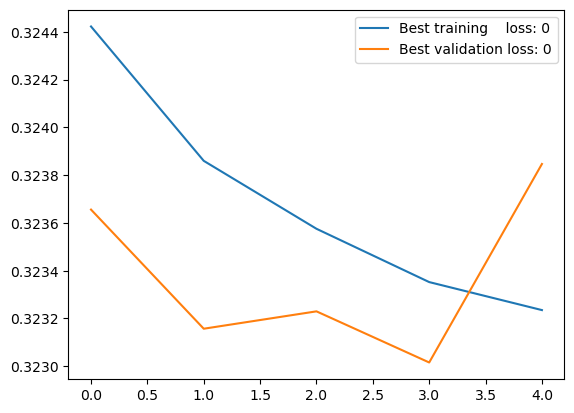

In [257]:
plt.plot(train_losses, label=f'Best training    loss: {min(train_losses):.0f}');
plt.plot(val_losses, label=f'Best validation loss: {min(val_losses):.0f}');
plt.legend();

In [258]:
for l in train_loader:
    G = l['G']
    adj = l['adj']
    break

In [265]:
adj

tensor([[[0., 1., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 1., 0., 0., 1., 0.],
         [1., 0., 0., 0., 1., 0., 0., 1.],
         [1., 1., 0., 0., 0., 1., 0., 0.],
         [1., 0., 1., 0., 0., 1., 0., 0.],
         [1., 0., 0., 1., 1., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 1., 0., 0., 0., 0., 0.]]], device='cuda:0')

In [264]:
(model(G.x) > 0.5).to(torch.int)

tensor([[0, 1, 1, 1, 1, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0', dtype=torch.int32)